In [1]:
# Install tfdiffeq if not already installed
!pip install --upgrade -q git+https://github.com/titu1994/tfdiffeq.git

In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx("float64")

In [2]:
from tfdiffeq import odeint, plot_results
from tfdiffeq.hyper_solvers import HyperEuler, HyperHeun

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Solver Hyper Network
Construct a small 3 layer feed-forward network to act as the Solver Hyper Network

In [4]:
class HyperSolverModule(tf.keras.Model):
  def __init__(self, func_input_dim, hidden_dim=64):
    super().__init__(dtype='float64')
    self.func_input_dim = func_input_dim
    
    # Input dim isnt used (Keras handled it automatically)
    # But for illustration purposes, it is provided
    # Computed as ~ dim(y) + dim(dy) + 1 (for time axis)
    self.input_dim = 2 * func_input_dim + 1
    self.hidden_dim = hidden_dim
    self.output_dim = func_input_dim

    self.g = tf.keras.Sequential([
        tf.keras.layers.Dense(self.hidden_dim),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(self.hidden_dim),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(self.hidden_dim),
        tf.keras.layers.PReLU(),
        tf.keras.layers.Dense(self.output_dim)
    ])
    
  @tf.function
  def call(self, x):
    return self.g(x)

# ODE Function
We will use the Lorenz Attractor (a chaotic ODE) as the function we want the hyper solver to model

In [5]:
class Lorenz(tf.keras.Model):

    def __init__(self, sigma=10., beta=8 / 3., rho=28.):
        super().__init__(dtype='float64')

        self.sigma = float(sigma)
        self.beta = float(beta)
        self.rho = float(rho)
    
    @tf.function
    def call(self, t, y0):
        """ y here is [x, y, z] """
        if len(y0.shape) == 1:
          x, y, z = tf.unstack(y0)
        else:
          x, y, z = tf.unstack(y0[0])
        
        dx_dt = self.sigma * (y - x)
        dy_dt = x * (self.rho - z) - y
        dz_dt = x * y - self.beta * z

        dL_dt = tf.stack([dx_dt, dy_dt, dz_dt])

        if len(y0.shape) == 1:
          return dL_dt
        else:
          return tf.expand_dims(dL_dt, axis=0)

# Lets first compute and visualize the ground truth

In [6]:
sigma = 10.
beta = 8. / 3.
rho = 28.

t = tf.range(0.0, 100.0, 0.01, dtype=tf.float64)
initial_states = tf.convert_to_tensor([1., 1., 1.], dtype=tf.float64)

In [7]:
%%time

with tf.device('cpu'):
    result = odeint(Lorenz(sigma, beta, rho), initial_states, t, rtol=1e-8, atol=1e-8)
print("Finished integrating ! Result shape : ", result.shape)

Finished integrating ! Result shape :  (10000, 3)
Wall time: 1min 12s


Text(0.5, 0.92, 'Lorenz Attractor')

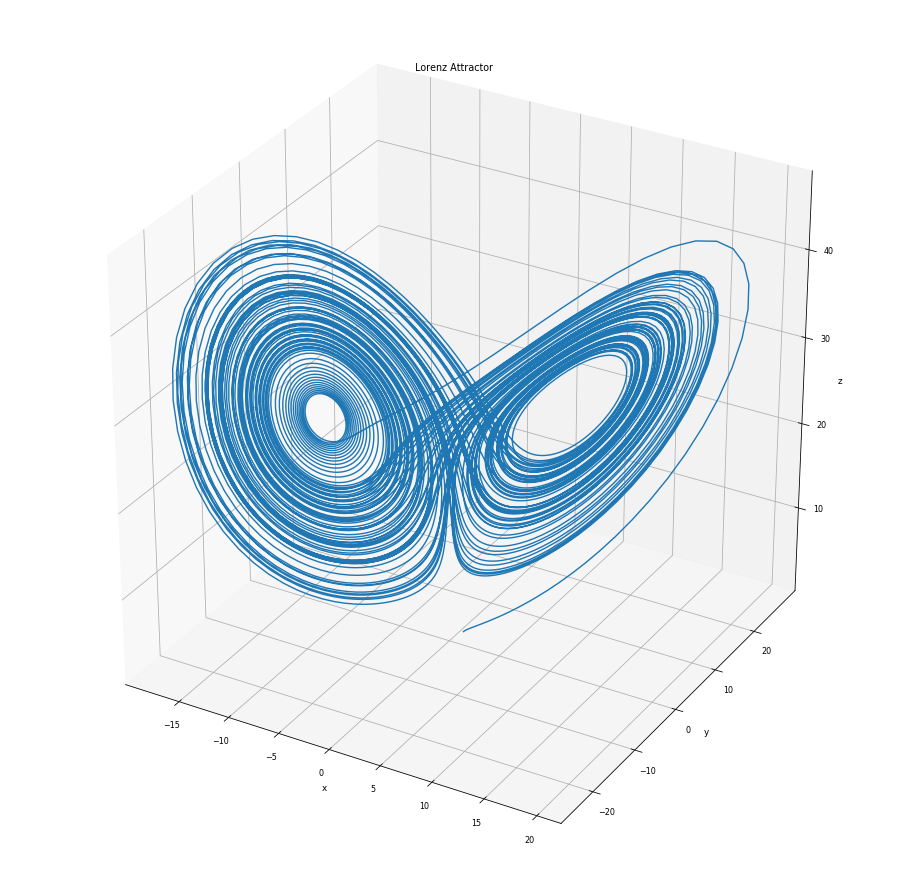

In [8]:
plot_results(t, result, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor')

# Initial Pretraining of Hyper Solver

In [9]:
f = Lorenz(sigma, beta, rho)
g = HyperSolverModule(func_input_dim=3, hidden_dim=64)

hyper_heun = HyperHeun(f, g)

HyperHeun is an experimental model, the API may change significantly !


In [10]:
epochs = 20
batch_size = 16
pretrain_batches = 100

In [11]:
%%time
pretrain_batch_data = result[:batch_size, :]

optim = tf.keras.optimizers.Adam(learning_rate=0.01)

for idx in range(pretrain_batches):
    with tf.GradientTape() as tape:
        output = hyper_heun.trajectory(t[:batch_size], initial_states[None, :])  # SHAPE = [batch_size, 1, 3]
        output = tf.reshape(output, (output.shape[0], -1))  # SHAPE = [batch_size, 3]
        loss = tf.reduce_sum((result[:batch_size] - output) ** 2)

    grads = tape.gradient(loss, hyper_heun.trainable_variables)
    optim.apply_gradients(zip(grads, hyper_heun.trainable_variables))
        
    if (idx + 1) % 10 == 0:
        print(f"Batch {idx + 1}: Loss = {loss.numpy()}")


Batch 10: Loss = 0.0003260862982550258
Batch 20: Loss = 3.271771868258704e-05
Batch 30: Loss = 7.797833322384907e-05
Batch 40: Loss = 2.558354006032643e-05
Batch 50: Loss = 3.140030832752013e-05
Batch 60: Loss = 2.457052061279884e-05
Batch 70: Loss = 2.465662615543939e-05
Batch 80: Loss = 2.3828654337474486e-05
Batch 90: Loss = 2.309212958682626e-05
Batch 100: Loss = 2.2571805332470488e-05
Wall time: 6.07 s


# Train the hyper solver to convergence

In [12]:
%%time 
num_samples = len(result)

sched = tf.keras.experimental.CosineDecay(0.01, decay_steps=num_samples * epochs // batch_size, alpha=1e-4)
optim = tf.keras.optimizers.Adam(learning_rate=sched, clipnorm=10.0)


def train_step(model, t, init_state, y, optimizer):
    with tf.GradientTape() as tape:        
        predictions = hyper_heun.trajectory(t, init_state)  # SHAPE = [batch_size, 1, 3]
        predictions = tf.reshape(predictions, (predictions.shape[0], -1))  # SHAPE = [batch_size, 3]

        loss = tf.reduce_sum((y - predictions) ** 2)
    
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss, predictions
    

global_steps = 0
for epoch in range(epochs):
  batch_idx = 0
  step = 1
  losses = []

  init_state = initial_states[None, :]

  while batch_idx < num_samples:    
    begin_idx = batch_idx
    end_idx = batch_idx + batch_size

    ground_samples = result[begin_idx: end_idx, :]
    t_samples = t[begin_idx: end_idx]
    init_state = ground_samples[0][None, :]
    
    loss, predictions = train_step(hyper_heun, t_samples, init_state, ground_samples, optim)

    losses.append(loss)
    
    lr = sched(global_steps)

    step += 1
    global_steps += 1
    batch_idx += batch_size

    if step % 20 == 0:
      print(f"Epoch {epoch + 1}, Step {step}: Loss = {loss.numpy()} | LR = {lr.numpy()}")

  average_loss = tf.reduce_mean(tf.stack(losses))
  print(f"End of epoch {epoch + 1}: Average loss = {average_loss.numpy()}")
  print()
    

Epoch 1, Step 20: Loss = 0.0003815304528909652 | LR = 0.009999948553740978
Epoch 1, Step 40: Loss = 0.0001277997161379543 | LR = 0.009999772533774376
Epoch 1, Step 60: Loss = 0.0005894066220194586 | LR = 0.009999468922615051
Epoch 1, Step 80: Loss = 0.0015639352809654074 | LR = 0.009999038651585579
Epoch 1, Step 100: Loss = 7.004452234910424e-06 | LR = 0.009998483583331108
Epoch 1, Step 120: Loss = 0.0015957056735979509 | LR = 0.00999780185520649
Epoch 1, Step 140: Loss = 0.0013069930660241774 | LR = 0.009996993467211723
Epoch 1, Step 160: Loss = 0.02799738950040157 | LR = 0.00999605841934681
Epoch 1, Step 180: Loss = 3.795143605179687e-05 | LR = 0.009994997642934322
Epoch 1, Step 200: Loss = 0.0010924580513921797 | LR = 0.009993811137974262
Epoch 1, Step 220: Loss = 0.0015974361313323697 | LR = 0.00999249704182148
Epoch 1, Step 240: Loss = 0.0005134740780458018 | LR = 0.009991059079766273
Epoch 1, Step 260: Loss = 5.4297041213468265e-05 | LR = 0.009989493526518345
Epoch 1, Step 280: L

# Evaluate using the Hyper Solver

In [13]:
def predict():
    with tf.device('cpu'):
        init_state = initial_states[None, :]  # [[1., 1., 1.]]

        predictions = hyper_heun.trajectory(t, init_state)  # SHAPE = [batch_size, 1, 3]
        predictions = tf.reshape(predictions, (predictions.shape[0], -1))  # SHAPE = [batch_size, 3]
    
    return predictions

In [14]:
%%timeit -r 3 -n 1

# First eval might be a bit slower than rest, therefore repeat 3 times to get average runtime
predict()

7.73 s ± 102 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [15]:
%%time

predictions = predict()

Wall time: 8.35 s


Text(0.5, 0.92, 'Lorenz Attractor (Ground Truth)')

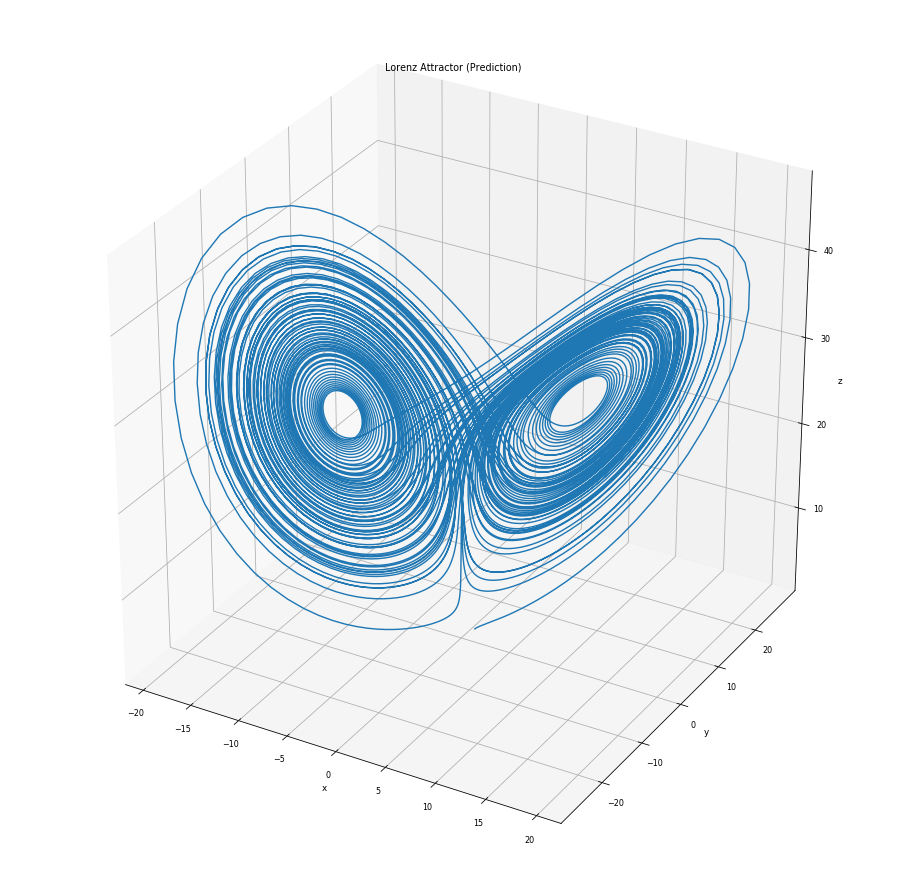

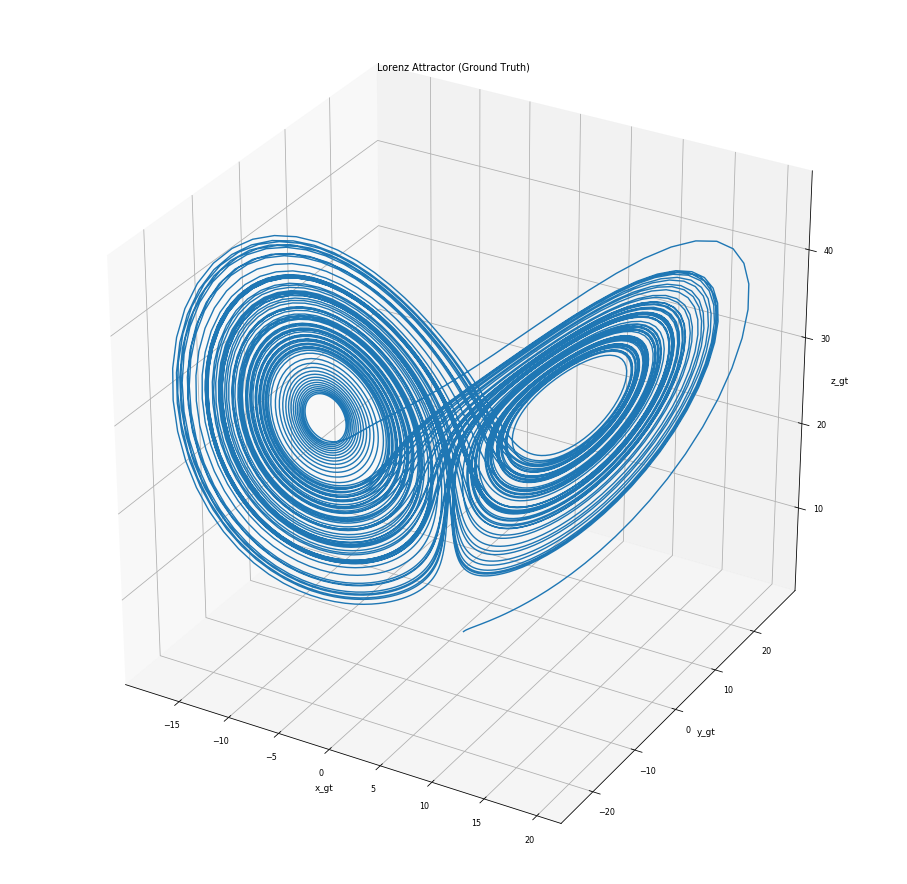

In [16]:
plot_results(t, predictions, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Prediction)')

plot_results(t, result, labels=['x_gt', 'y_gt', 'z_gt'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Ground Truth)')

## As can be seen, the difference between prediction and ground truth is quite a bit
We analyse below the per time step difference between result and prediction

Text(0.5, 0.92, 'Lorenz Attractor (Difference)')

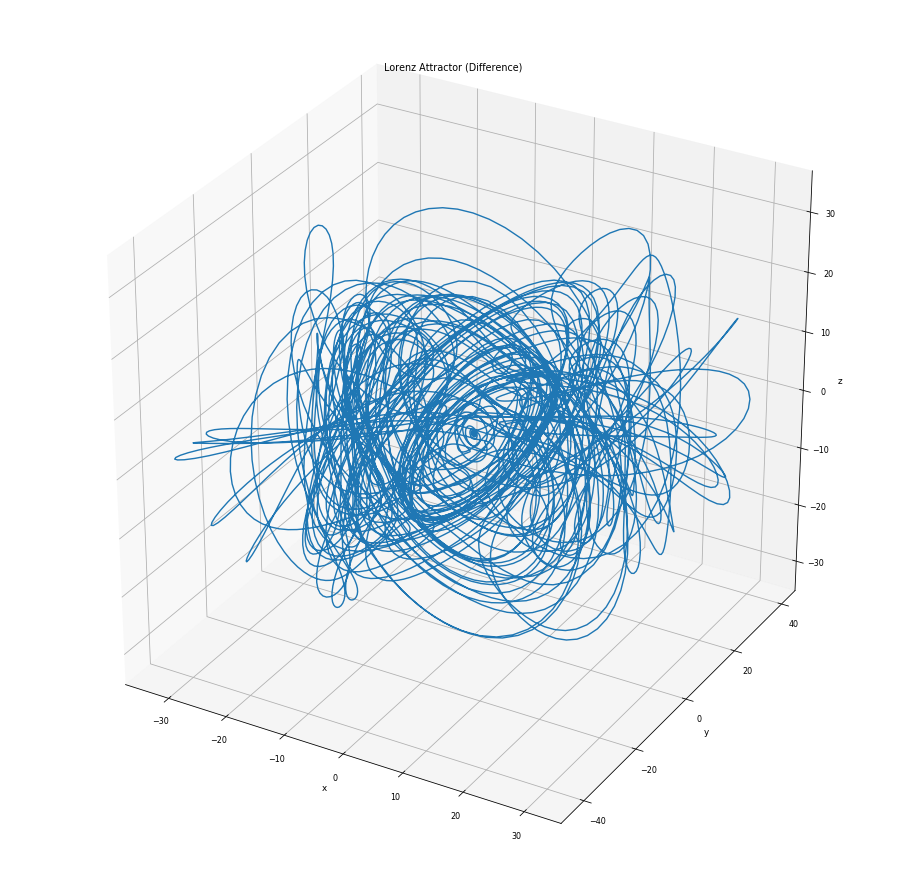

In [17]:
plot_results(t, result - predictions, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Difference)')

In [18]:
mse = tf.reduce_mean((result - predictions) ** 2, axis=0)
print("Mean squared error between Ground truth and prediction (overall): ", mse.numpy().mean())
print("Mean squared error between Ground truth and prediction (per axis): ", mse.numpy())

Mean squared error between Ground truth and prediction (overall):  120.5571178992138
Mean squared error between Ground truth and prediction (per axis):  [101.01189907 130.88205683 129.77739781]


## Lets plot the per timestep error, per variable

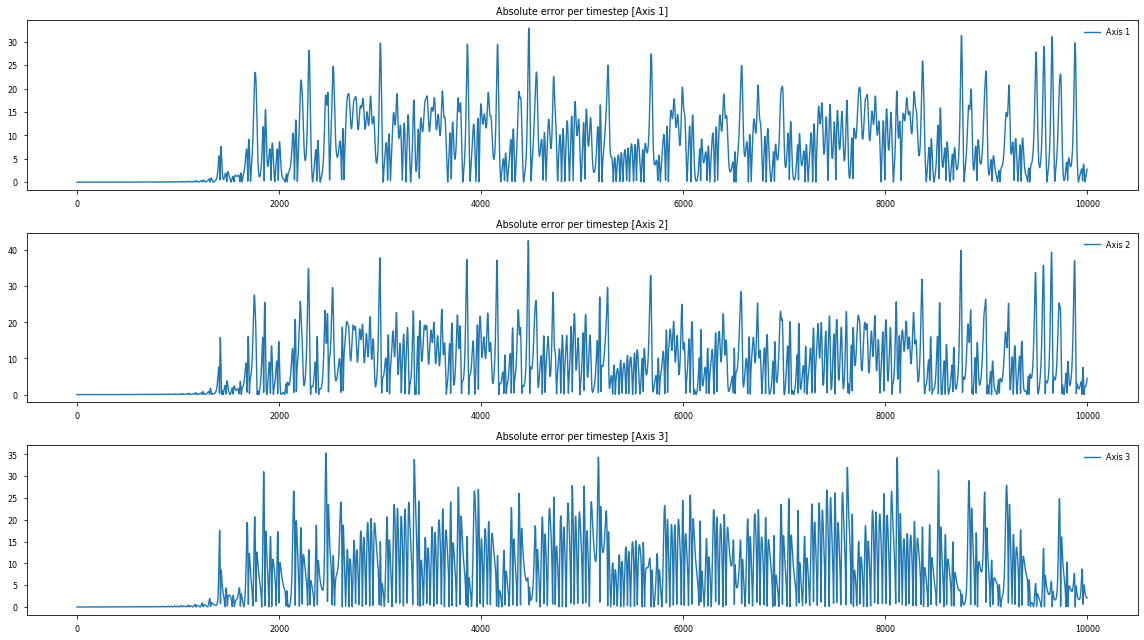

In [25]:
abs_error = tf.abs(result - predictions)

fig, axes = plt.subplots(3, 1, figsize=(16, 9))

for axis in range(result.shape[-1]):
    plt.sca(axes[axis])
    axis_error = abs_error[:, axis]
    plt.plot(axis_error, label=f'Axis {axis + 1}')
    
    plt.title(f"Absolute error per timestep [Axis {axis + 1}]")
    plt.legend()
    
plt.tight_layout()


# Result
The large above error is primarily due to the fact that the Lorenz Attractor exhibits chaotic behaviour, and is very sensitive to initial and intermediate state. 

Even minor changes severely impact the final result. During training, we provide the actual ground truth state as initial state for the model per batch, to allow the model to learn properly, but during evaluation it has no ground truth to refer to.

The minor errors it accumulates per time step adds up quickly and lead to different solutions.

In [27]:
def predict_with_ground_truth_states(batch_size=128):
    with tf.device('cpu'):
        batch_idx = 0
        preds = []
        
        # Start with Initial Value
        init_state = initial_states[None, :]

        while batch_idx < num_samples:    
            begin_idx = batch_idx
            end_idx = batch_idx + batch_size

            t_samples = t[begin_idx: end_idx]
            
            # Reset model's initial state to ground truth state at this timestep (to mimic training behaviour)
            init_state = result[begin_idx][None, :]

            predictions = hyper_heun.trajectory(t_samples, init_state)  # SHAPE = [batch_size, 1, 3]
            predictions = tf.reshape(predictions, (predictions.shape[0], -1))  # SHAPE = [batch_size, 3]
            preds.append(predictions)

            batch_idx += batch_size

        predictions = tf.concat(preds, axis=0)
    
    return predictions

In [28]:
%%time

gt_predictions = predict_with_ground_truth_states(batch_size=128)

Wall time: 8.07 s


Text(0.5, 0.92, 'Lorenz Attractor (Ground Truth)')

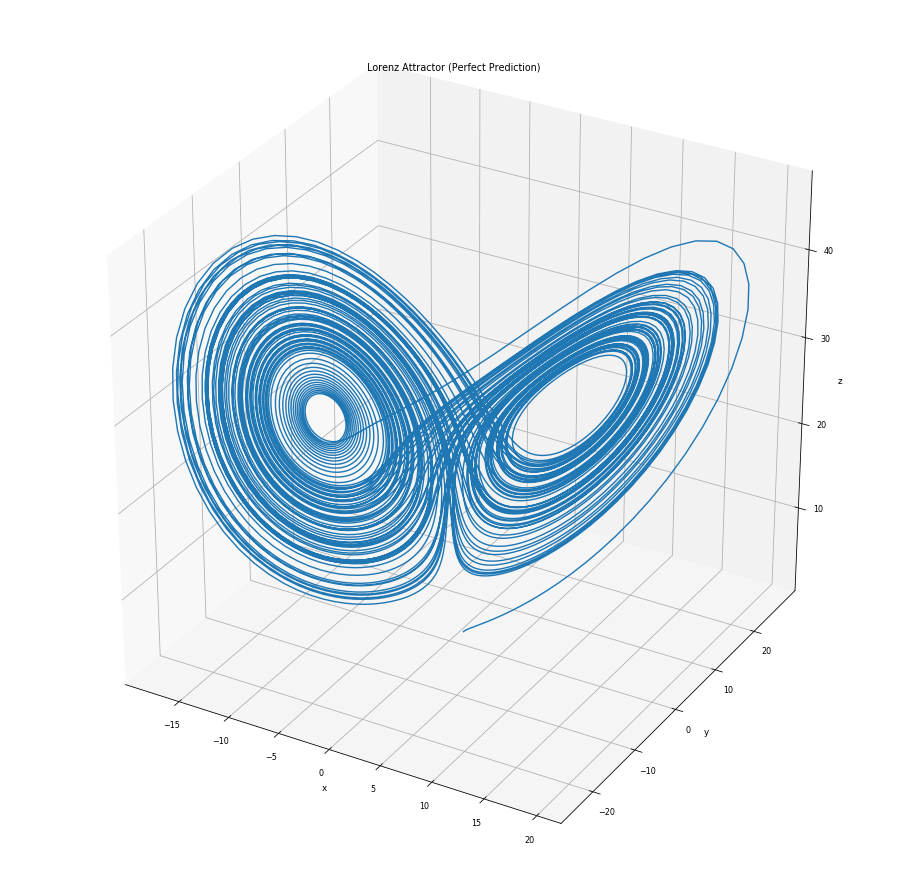

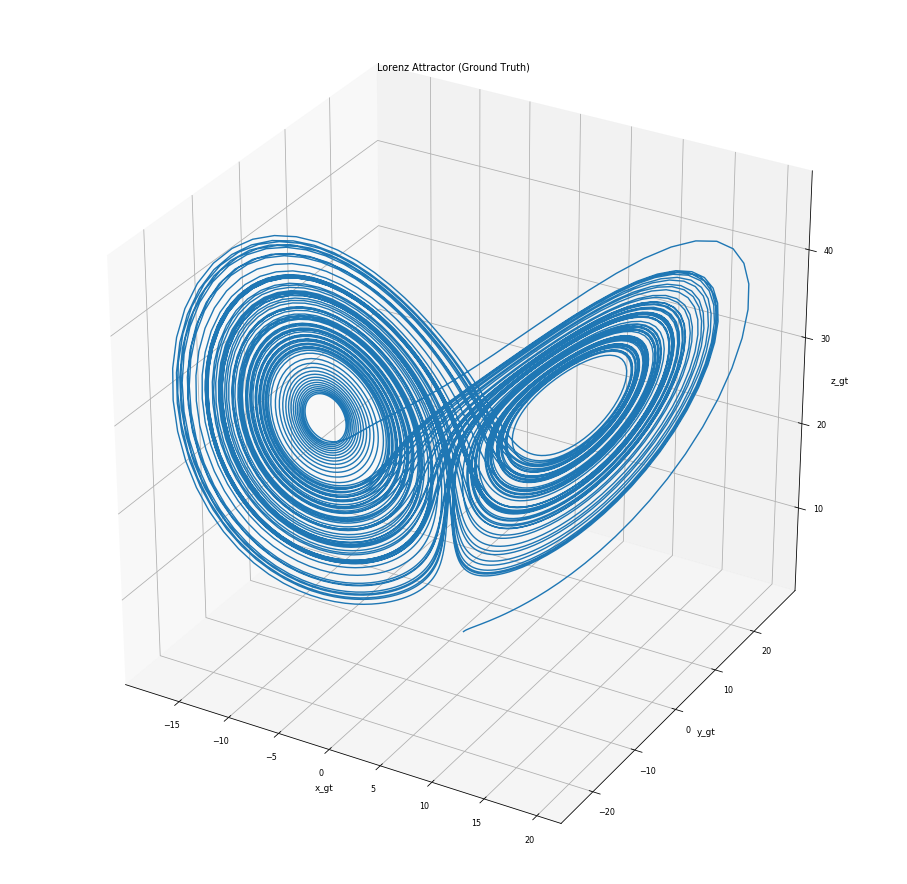

In [29]:
plot_results(t, gt_predictions, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Perfect Prediction)')

plot_results(t, result, labels=['x_gt', 'y_gt', 'z_gt'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Ground Truth)')

## Much better result (as expected)
Since we override the model's incorrect intermediate step at every batch, and replace it with ground truth state, the model is able to correctly produce (to a degree) a close approximate to ground truth.

Note, we used batch size 16 during training (approximately 630 steps per epoch) vs batch size 128 here (approximately 78 steps per epoch). Even with much 8x less corrections overall, the model still performs quite well with ground truth override of the initial state once every 128 timesteps.

Text(0.5, 0.92, 'Lorenz Attractor (Difference)')

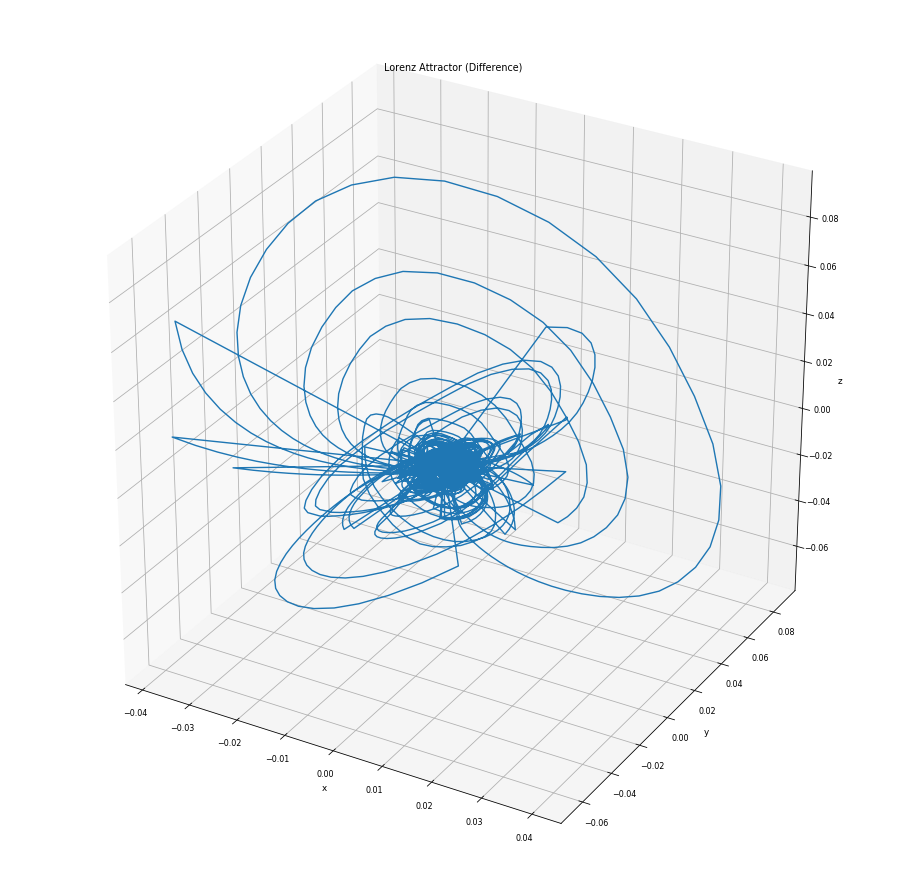

In [30]:
plot_results(t, result - gt_predictions, labels=['x', 'y', 'z'], dependent_vars=True, figsize=(16, 16))
plt.title('Lorenz Attractor (Difference)')

In [31]:
mse = tf.reduce_mean((result - gt_predictions) ** 2, axis=0)
print("Mean squared error between Ground truth and prediction (overall): ", mse.numpy().mean())
print("Mean squared error between Ground truth and prediction (per axis): ", mse.numpy())

Mean squared error between Ground truth and prediction (overall):  4.538426221293673e-05
Mean squared error between Ground truth and prediction (per axis):  [1.92999146e-05 4.93043967e-05 6.75484754e-05]


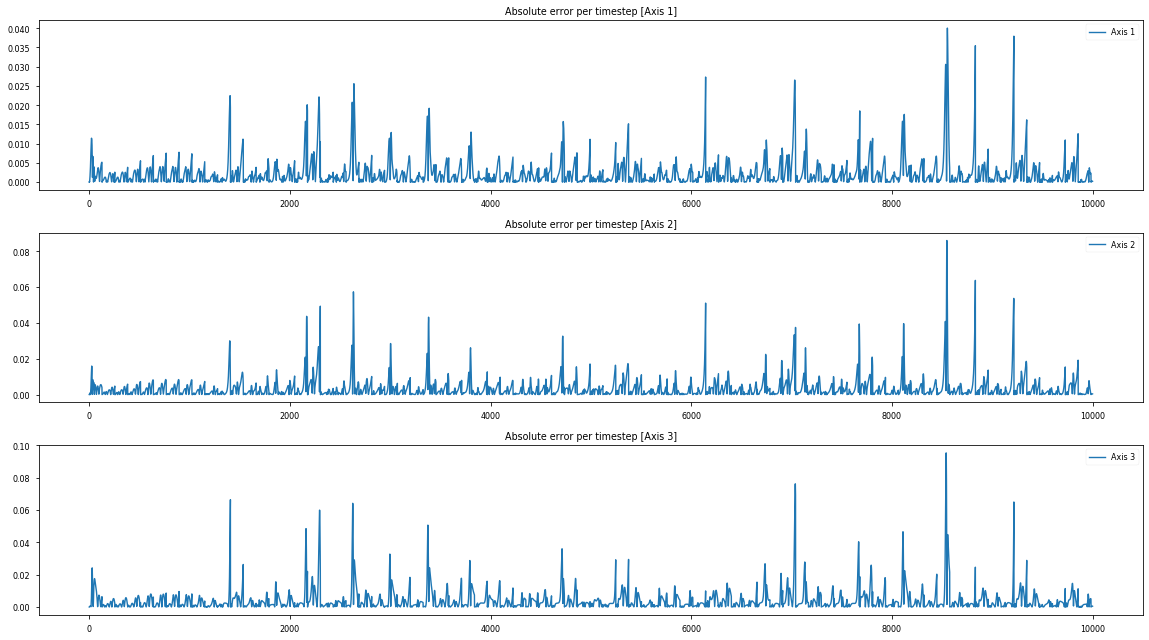

In [32]:
abs_error = tf.abs(result - gt_predictions)

fig, axes = plt.subplots(3, 1, figsize=(16, 9))

for axis in range(result.shape[-1]):
    plt.sca(axes[axis])
    axis_error = abs_error[:, axis]
    plt.plot(axis_error, label=f'Axis {axis + 1}')
    
    plt.title(f"Absolute error per timestep [Axis {axis + 1}]")
    plt.legend()
    
plt.tight_layout()